In [34]:
%matplotlib inline

# Calculation of Vertical Dynamic Ocean Modes #

Based on http://woodshole.er.usgs.gov/operations/sea-mat/klinck-html/dynmodes.html
by John Klinck, 1999.

The goal is to create a Python function that calculates numerical solutions of the generalized eigenvalue problem expressed by:

$$\frac{\partial^2}{\partial z^2} w_m + \alpha^2 N^2 w_m = 0$$

with boundary conditions of $w_m = 0$ at the surface and the bottom.

Variables:

* $z$ is the vertical coordinate, measured in $[m]$
* $w_m$ are the vertical velocity modes
* $N^2$ is a profile of Brunt-Vaisala buoyancy frequencies $[s^{-2}]$
* $\alpha^2$ are the eigenvalues

The inputs to our Python function will be:

* `Nsq`: an array of Brunt-Vaisala buoyancy frequencies $[s^{-2}]$ ; i.e. $N^2$
* `depth`: an array of depths $[m]$ that will be used as the vertical coordinates; i.e. $z$
* `nmodes`: number of vertical modes to calculate 

The outputs will be:

* `wmodes`: the array of vertical velocity modes; i.e. $w_m$
* `pmodes`: the array of horizontal velocity modes
* `rmodes`: the array of vertical density modes
* `ce`: the array of modal wave speeds $[m / s]$

We start by importing the Python libraries that we need to do the calculation:

* `numpy` is a high performance N-dimensional array library ([http://www.numpy.org/]())
* `scipy.linalg` is the SciPy linear algebra package that includes a generalized eigen-solver
  ([http://docs.scipy.org/doc/scipy/reference/tutorial/linalg.html]())
* `matplotlib.pyplot` is a MATLAB-like plotting framework ([http://matplotlib.org/]())

In [35]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

We going to break the implementation into 3 functions to improve readability and testability of the code.
First:

`build_d2dz_matrix`: 

  * build the matrix that discretized $\frac{\partial^2}{\partial z^2}$ over the vertical coordinate,
    and applies the boundary conditions

In [36]:
def build_d2dz2_matrix(depth):
    """Build the matrix that discretizes the 2nd derivative
    over the vertical coordinate, and applies the boundary conditions.
    """
    zed = -depth
    # Number and size (in [m]) of vertical coordinate grid steps
    nz = zed.size
    dz = zed[:nz - 1] - zed[1:]
    # Grid step midpoints
    z_mid = zed[:nz - 1] - 0.5 * dz[:nz - 1]
    # Size of steps between grid step midpoints
    dz_mid = np.zeros_like(zed)
    dz_mid[1:dz_mid.size - 1] = z_mid[:nz - 2] - z_mid[1:nz - 1]
    dz_mid[0] = dz_mid[1]
    dz_mid[dz_mid.size - 1] = dz_mid[dz_mid.size - 2]
    # 2nd derivative matrix matrix
    d2dz2 = np.zeros((nz, nz))
    # Elements on the diagonal
    diag_index = np.arange(1, nz - 1)
    d2dz2[diag_index, diag_index] = (
        1 / (dz[:nz - 2] * dz_mid[1:nz - 1]) + 1 / (dz[1:nz - 1] * dz_mid[1:nz - 1]))
    # Elements on the super-diagonal
    diag_index_p1 = np.arange(2, nz)
    d2dz2[diag_index, diag_index_p1] = -1 / (dz[:nz - 2] * dz_mid[1:nz - 1])
    # Elements on the sub-diagonal
    diag_index_m1 = np.arange(nz - 2)
    d2dz2[diag_index, diag_index_m1] = -1 / (dz[1:nz - 1] * dz_mid[1:nz - 1])
    # Boundary conditions
    d2dz2[0, 0] = d2dz2[nz - 1, 0] = -1
    return d2dz2, nz, dz

Once the eigenvalues and modes have been calculated,
we need to clean up numerical artifacts,
and prepare the eigenvalues and modes to be output:

`clean_up_modes`:

  * exclude complex-valued (non-physical) eigenvalues and their corresponding modes
  * exclude near-zero and negative eigenvalues and their corresponding modes
  * sort the eigenvalues and modes by increasing eigenvalue magnitude
  * truncate the set to the number of modes that were requested for the calculation.

In [37]:
def clean_up_modes(eigenvalues, wmodes, nmodes):
    """Exclude complex-valued and near-zero/negative eigenvalues and their modes.
    Sort the eigenvalues and mode by increasing eigenvalue magnitude,
    and truncate the results to the number of modes that were requested.
    """
    # Transpose modes to that they can be handled as an array of vectors
    wmodes = wmodes.transpose()
    # Filter out complex-values and small/negative eigenvalues and corresponding modes
    mask = np.imag(eigenvalues) == 0
    eigenvalues = eigenvalues[mask]
    wmodes = wmodes[mask]
    mask = eigenvalues >= 1e-10
    eigenvalues = eigenvalues[mask]
    wmodes = wmodes[mask]
    # Sort eigenvalues and modes and truncate to number of modes requests
    index = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[index[:nmodes]]
    wmodes = wmodes[index[:nmodes]]
    return eigenvalues, wmodes

Finally,
we put everythng together:

`dynmodes`:

  * build the del-squared matrix
  * solve the generalized eigenvalue problem
  * clean up the eigenvalue and vertical mode results
  * calculate the modal speeds
  * calculate the horizontal modes by differention of the vertical modes

In [38]:
def dynmodes(Nsq, depth, nmodes):
    """Calculate ocean dynamic vertical modes
    taking a column vector of Brunt-Vaisala values (Nsq) at
    different depths (depth) and calculating some number of 
    dynamic modes (nmodes).

    Based on http://woodshole.er.usgs.gov/operations/sea-mat/klinck-html/dynmodes.html
    by John Klinck, 1999.
    """
    # 2nd derivative matrix plus boundary conditions
    d2dz2, nz, dz = build_d2dz2_matrix(depth)
    # N-squared diagonal matrix
    Nsq_mat = np.identity(nz) * Nsq
    # Solve generalized eigenvalue problem for eigenvalues and vertical velocity modes
    eigenvalues, wmodes = scipy.linalg.eig(d2dz2, Nsq_mat)
    eigenvalues, wmodes = clean_up_modes(eigenvalues, wmodes, nmodes)
    # Vertical density modes
    rmodes = wmodes * Nsq
    # Modal speeds
    ce = np.real(1 / np.sqrt(eigenvalues))
    # Horizontal velocity modes
    pmodes = np.zeros_like(wmodes)
    # 1st derivative of vertical modes
    pr = np.diff(wmodes) / dz
    # Linear interpolation on to the vertical coordinate grid
    pmodes[:, 1:nz - 1] = (pr[:, 1:nz - 1] + pr[:, :nz - 2]) / 2
    pmodes[:, 0] = pr[:, 0]
    pmodes[:, nz - 1] = pr[:, nz - 2]
    return wmodes, pmodes, rmodes, ce

# Test Case #1 #
Unit depth and uniform, unit $N^2$

Analytical solution is:
$$w_m = w_o \sin(\frac{z}{ce})$$
where
$$ce = \frac{1}{n \pi}$$

and $w_o$ is an arbitrary constant, taken as 1

In [39]:
depth1 = np.arange(0, 1.05, 0.05)
Nsq1 = np.ones_like(depth1)
wmodes1, pmodes1, rmodes1, ce1 = dynmodes(Nsq1, depth1, 3)
print (ce1)

[ 0.31863737  0.15981133  0.10709144]


In [40]:
const = 1 / np.pi
analytical = np.array((const, const / 2, const / 3))
print (analytical)

[ 0.31830989  0.15915494  0.1061033 ]


Let's define a helper function to plot $N^2$ and the 3 sets of modes returned by `dynmodes`:

In [53]:
def plot_modes(Nsq, depth, nmodes, wmodes, pmodes, rmodes):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(2, 2, 1)
    # Nsq
    ax.plot(Nsq, -depth)
    ax.ticklabel_format(style='sci', scilimits=(2, 2), axis='x')
    ax.set_ylabel('z')
    ax.set_xlabel('N^2')
    # modes
    mode_sets = [
      # (values, subplot number, x-axis title)
        (wmodes, 2, 'wmodes'),
        (pmodes, 3, 'pmodes'),
        (rmodes, 4, 'rmodes'),
    ]
    for mode_set in mode_sets:
        modes, subplot, title = mode_set
        ax = fig.add_subplot(2, 2, subplot)
        for i in range(nmodes):
            ax.plot(modes[i], -depth, label='mode {}'.format(i))
        ax.ticklabel_format(style='sci', scilimits=(3, 3), axis='x')
        ax.set_ylabel('z')
        ax.set_xlabel(title)
        ax.legend()
    

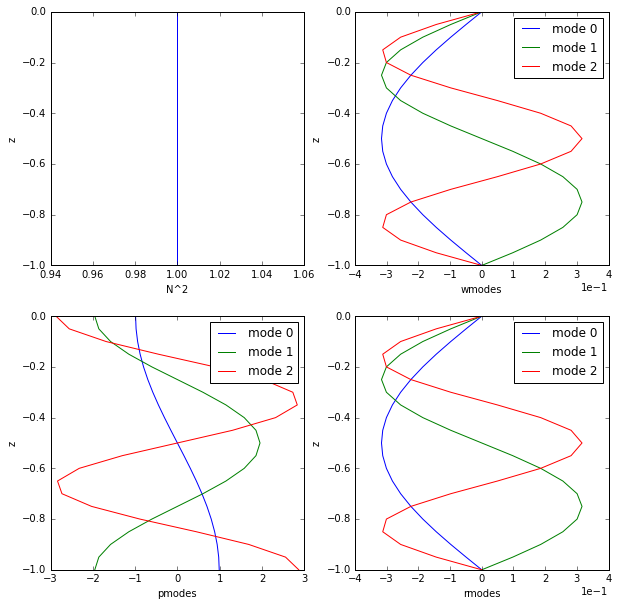

In [54]:
plot_modes(Nsq1, depth1, 3, wmodes1, pmodes1, rmodes1)

# Test Case #2 #
400 m depth at 10 m intervals

Uniform $N^2 = 1 \times 10^{-6} \ s^{-2}$

Analytical solution is:
$$w_m = w_o \sin(\frac{N z}{ce})$$
where
$$ce = \frac{N H}{n \pi}, N = 1 \times 10^{-3} \ s_{-2}, H = 400 \ m$$

In [66]:
depth2 = np.linspace(0, 400., 41)
Nsq2 = np.ones_like(depth2) * 1e-6
Nsq2[:10] = 1e-8
Nsq2[30:] = 1e-8

wmodes2, pmodes2, rmodes2, ce2 = dynmodes(Nsq2, depth2, 3)
print(ce2)

[ 0.11635548  0.04949719  0.02943275]


In [67]:
const = 1e-3 * 400 / np.pi
analytical = np.array((const, const / 2, const / 3))
print(analytical)

[ 0.12732395  0.06366198  0.04244132]


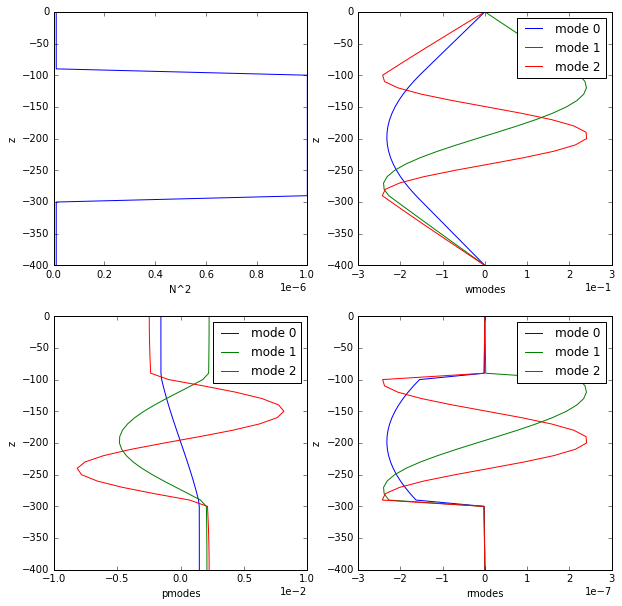

In [68]:
plot_modes(Nsq2, depth2, 3, wmodes2, pmodes2, rmodes2)

# Exercise #

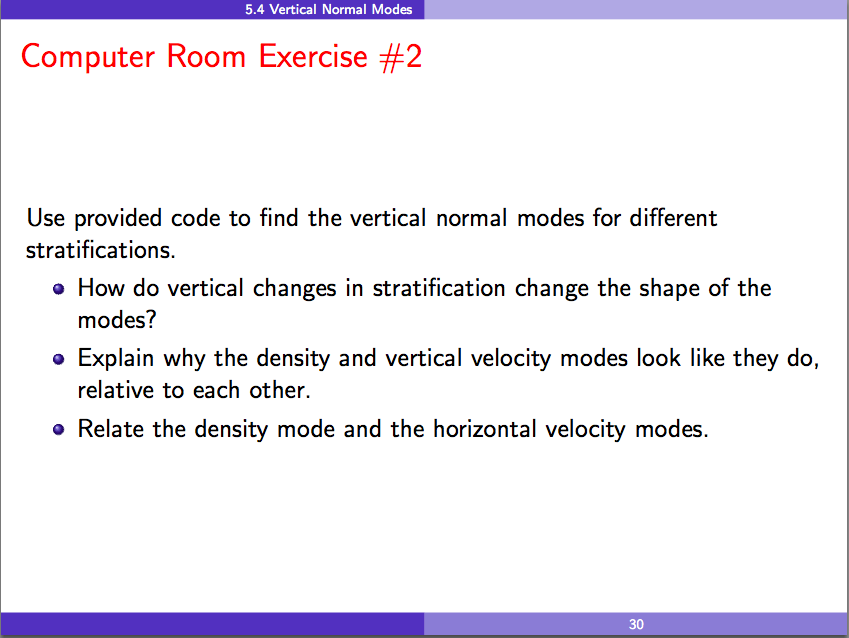

In [46]:
from IPython.core.display import Image 
Image(filename='aims_allen_exercise_2.png')

There are a selection of density profile files:

In [47]:
ls *.dens

SoG_S3.dens  s105.dens    s109.dens    so550.dens


`SoG_S3.dens` is from the Strait of Georgia on the west coast of Canada

`s105.dens` and `s109.dens` are from Florida Straits

`so550.dens` is from the South Atlantic offshore of Cape Town

This pair of functions will read a named file and return depth and density arrays:

In [48]:
def interesting_lines(f):
    for line in f:
        if line and not line.startswith('#'):
            yield line

def read_density_profile(filename):
    """Return depth and density arrays read from filename.
    """
    depth = []
    density = []
    with open(filename) as f:
        for line in interesting_lines(f):
            deep, rho = map(float, line.split())
            depth.append(deep)
            density.append(rho)
    return np.array(depth), np.array(density)

Here's a convenience function that calculates the $N^2$ profile for a given density profile:

In [49]:
def density2Nsq(depth, density, rho0=1028):
    """Return the Brunt-Vaisala buoyancy frequency (Nsq) profile
    corresponding to the given density profile.
    The surface Nsq value is set to the value of the 1st calculated value
    below the surface.
    Also return the depths for which the Brunt-Vaisala buoyancy frequencies
    were calculated.
    """
    grav_acc = 9.8  # m / s^2
    Nsq = np.zeros_like(density)
    Nsq[1:] = np.diff(density) * grav_acc / (np.diff(depth) * rho0)
    Nsq[0] = Nsq[1]
    Nsq[Nsq < 0] = 0
    Nsq_depth = np.zeros_like(depth)
    Nsq_depth[1:] = (depth[:depth.size - 1] + depth[1:]) / 2
    return Nsq_depth, Nsq

# Unit Tests #

In [50]:
# Tests for build_d2dz2_matrix function
def test_build_d2dz2_matrix_n_steps():
    """build_d2dz2_matrix returns number of vertical coordinate grid steps
    """
    depth = np.linspace(0, 1, 3)
    d2dz2, nz, dz = build_d2dz2_matrix(depth)
    assert nz == 3
    

# Tests for depth2Nsq function
def test_depth2Nsq_Nsq():
    """depth2Nsq returns expected Nsq array
    """
    depth = np.linspace(1, 4, 4)
    density = np.linspace(1028, 1031, 4)
    Nsq_depth, Nsq = density2Nsq(depth, density)
    np.testing.assert_equal(Nsq, np.array([9.8 / 1028] * 4))
    
def test_depth2Nsq_Nsq_depth():
    """depth2Nsq returns expected Nsq_depth array
    """
    depth = np.linspace(1, 4, 4)
    density = np.linspace(1028, 1031, 4)
    Nsq_depth, Nsq = density2Nsq(depth, density)
    np.testing.assert_equal(Nsq_depth, np.array([0, 1.5, 2.5, 3.5]))
    
def test_depth2Nsq_Nsq_no_neagative_values():
    """depth2Nsq clamps negative Nsq values to zero
    """
    depth = np.linspace(1, 4, 4)
    density = np.array([1028., 1029., 1030., 1029.])
    Nsq_depth, Nsq = density2Nsq(depth, density)
    np.testing.assert_equal(Nsq, np.array([9.8 / 1028] * 3 + [0]))

Run the test suite.

All we're doing here is calling each test function.
Success of the assertions in all tests will result in no output.
A failed assertion will stop the execution of the cell and give
us a traceback describing the failure.

Try changing a value in one of the test assertions to see a failure.

This is a "quick and dirty" way of running the test suite in the context
of an iPython Notebook.
It's not very robust because you have to remember to explicitly add a call 
for each test function.
Nor is it as informative as it could be because it stops after the first
test failure instead of telling us about all of the test failures.
For Python code written in modules (in constrast to a Notebook) those
shortcomings can be addressed by using a unit test framework such as:

* the [unittest module](http://docs.python.org/2.7/library/unittest.html) in the Python standard library
* the [py.test](http://pytest.org/) package
* the [nose](https://nose.readthedocs.org/) package

All of those frameworks provide automatic test discovery to avoid the explicit
list of tests,
and many options for more informative reporting of test results for both
successful and failed tests.

In [51]:
# build_d2dz2_matrix()
test_build_d2dz2_matrix_n_steps()

# depth2Nsq()
test_depth2Nsq_Nsq()
test_depth2Nsq_Nsq_depth()
test_depth2Nsq_Nsq_no_neagative_values()

print('Congratulations! All tests passed.')

Congratulations! All tests passed.
